In [163]:
# The usual preamble
import pandas as pd
import numpy as np
import pandas_datareader.data as web

%pylab inline
# Make the graphs a bit prettier, and bigger
pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.line_width', 5000) 
pd.set_option('display.max_columns', 60) 

Populating the interactive namespace from numpy and matplotlib
line_width has been deprecated, use display.width instead (currently both are
identical)



`%matplotlib` prevents importing * from pylab and numpy


In [164]:
start, end = datetime.datetime(2010,1,1), datetime.datetime(2011,1,1)
ford = web.DataReader('F', 'yahoo', start, end)

In [165]:
ford.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,10.17,10.28,10.05,10.28,60855800,8.418735
2010-01-05,10.45,11.24,10.40,10.96,215620200,8.975616
2010-01-06,11.21,11.46,11.13,11.37,200070600,9.311383
2010-01-07,11.46,11.69,11.32,11.66,130201700,9.548876
2010-01-08,11.67,11.74,11.46,11.69,130463000,9.573444


In [166]:
log_returns = np.log(ford['Close'] / ford['Close'].shift(1))
log_returns.head()

Date
2010-01-04         NaN
2010-01-05    0.064052
2010-01-06    0.036726
2010-01-07    0.025186
2010-01-08    0.002570
Name: Close, dtype: float64

In [167]:
mu = log_returns.mean() * 252
print mu

0.492537785644


In [168]:
sigma = log_returns.std() * 252 ** 0.5
print sigma

0.38105389218


In [169]:
def option_price(K, T, S0, r, sigma, sim_count, payoff, dt = (1.0 / 365)):

    sim_length = int(T/dt) # in days

    rand = np.random.standard_normal((sim_length,sim_count))
    sims = np.zeros_like(rand)
    sims[0] = S0

    for t in xrange(1,sim_length):
        sims[t] = sims[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * dt ** 0.5 * rand[t])

    price = np.exp(-r * T) * ( payoff(sims, K).sum() / sim_count )
    
    return price

payoff_euro_call = lambda sims, K: np.maximum(sims[-1]-K, 0)
payoff_euro_put = lambda sims, K: np.maximum(K-sims[-1], 0)
payoff_digital_call = lambda sims, K: np.maximum(np.sign(sims[-1]-K), 0)
payoff_digital_put = lambda sims, K: np.maximum(np.sign(K-sims[-1]), 0)

p = option_price(
    K = 13,
    T = 1.0/52,
    S0 = 13.13,
    r = 0.02, # risk-free rate
    sigma = sigma,
    payoff = payoff_euro_call,
    sim_count = 10000
)
p


0.32734658777314912

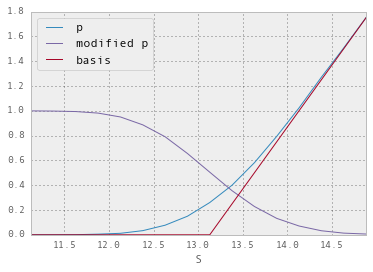

In [170]:
def frange(a,b,step):
    while a<b:
        yield a
        a+= step

sims = 10000
K = 13.13
mat = 1.0/52
hockey = pd.DataFrame([(s, 
                        option_price(K, mat, s, 0.01, sigma, sims, payoff_euro_call),
#                         option_price(K, mat, s, 0.01, sigma, sims, payoff_digital_call),
                        option_price(K, mat, s, 0.01, sigma, sims, payoff_digital_put),
#                         option_price(K, mat, s, 0.01, sigma/10, sims, payoff_digital_call),
#                         option_price(K, mat, s, 0.01, sigma, sims, payoff_euro_put),
#                         option_price(K, mat, s, 0.01, sigma, sims/100, payoff_euro_call),
#                         option_price(K, mat, s, 0.01, sigma/2, sims, payoff_euro_call),
#                         option_price(K, 2*mat, s, 0.01, sigma, sims, payoff_euro_call),
#                         option_price(K, mat, s, 0.1, sigma, sims, payoff_euro_call),
                        np.maximum(s-K, 0), 
                       ) for s in frange(K-2,K+2,0.25)], 
                      columns=['S','p','modified p', 'basis'])
hockey.set_index(['S'], inplace=True, drop=True)
hockey.plot()